**Table of contents**<a id='toc0_'></a>    
- [Exploratory Data Analysis](#toc1_1_)    
- [Using LGBM and XGBOOST](#toc1_2_)    
  - [With backtesting](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [94]:
import pandas as pd
import numpy as np

In [95]:
df=pd.read_csv('../data/INDIAVIX.csv')
df.head()

,Date,Open,High,Low,Close,Previous,Change,%Change
0,2009-03-02,43.19,43.38,41.44,43.17,NaN,0.00,0.0000
1,2009-03-03,43.17,43.90,41.20,43.89,43.17,0.72,0.0167
2,2009-03-04,43.89,43.89,42.16,42.52,43.89,-1.37,-0.0312
3,2009-03-05,42.52,42.71,40.41,41.49,42.52,-1.03,-0.0242
4,2009-03-06,41.49,41.49,37.57,38.16,41.49,-3.33,-0.0803


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3061 entries, 0 to 3060
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3061 non-null   object 
 1   Open      3061 non-null   float64
 2   High      3061 non-null   float64
 3   Low       3061 non-null   float64
 4   Close     3061 non-null   float64
 5   Previous  3060 non-null   float64
 6   Change    3061 non-null   float64
 7   %Change   3061 non-null   float64
dtypes: float64(7), object(1)
memory usage: 191.4+ KB


In [97]:
# dropping the first row because, there is no prior data for "Previous column"
df.drop(0,inplace=True)

In [98]:
# transforming to datetime
df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')
df = df.sort_values(by="Date",ascending=True)

In [99]:
# turns out that there is 1 missing value in Previous column
df.isna().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Previous    0
Change      0
%Change     0
dtype: int64

<Axes: xlabel='Date', ylabel='Change'>

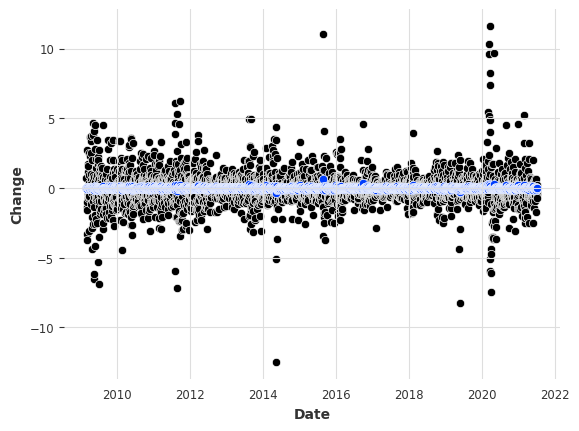

In [100]:
import seaborn as sns
sns.scatterplot(data=df,x='Date',y='Change')
sns.scatterplot(data=df,x='Date',y='%Change')
#The below diagram tells me about the volatility of the indices during 2016, 2020 and 2021
#Maybe because of covid-19

<Axes: xlabel='Date', ylabel='Change'>

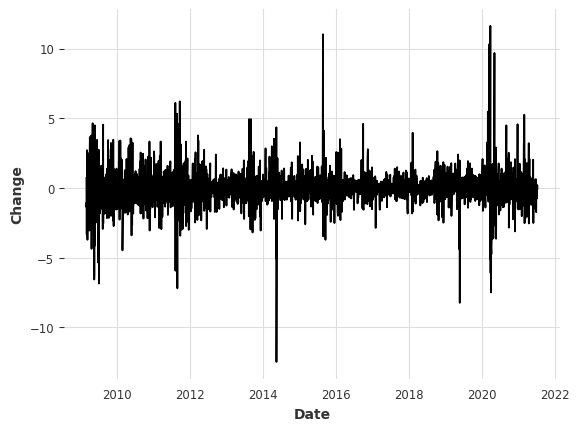

In [101]:
# time series as a lineplot
sns.lineplot(data=df,x='Date', y='Change')

* sns.scatterplot(df['Date'],df['Change'])
* Decreasing trend of prices observed 
* There was a huge price spike shortly after 2020(Prob. because investors wanted to take advantage of volatility)
* There is also a cyclical process happening to the dataset

## <a id='toc1_1_'></a>[Exploratory Data Analysis](#toc0_)

In [102]:
print(df['Date'].min())
print(df['Date'].max())

2009-03-03 00:00:00
2021-07-07 00:00:00


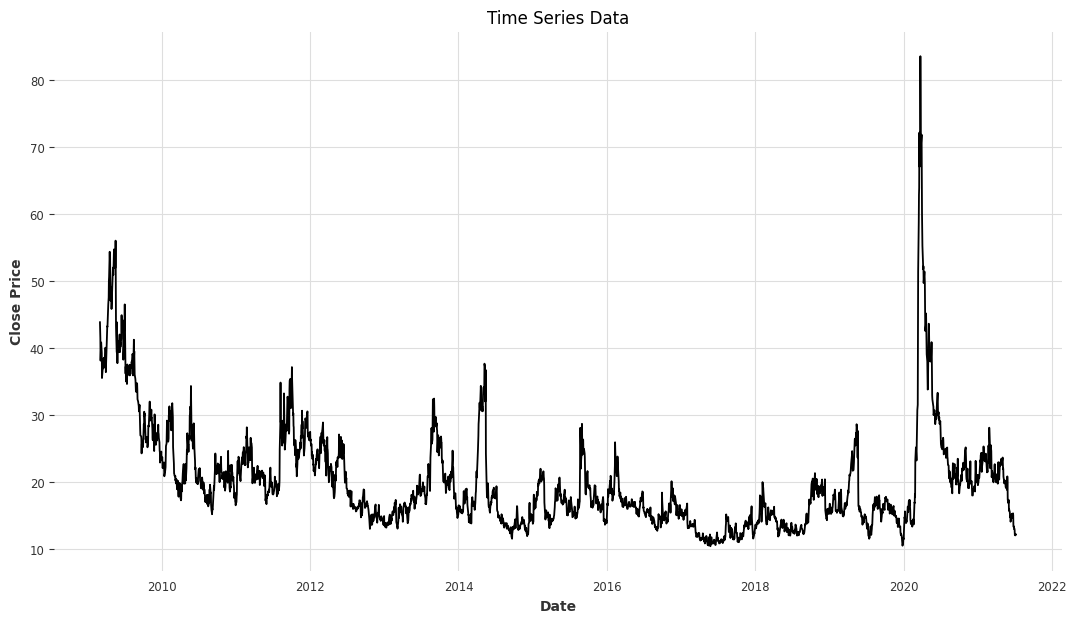

ADF Statistic: -4.870391323466932
p-value: 3.9810159024569805e-05
Critical Values: {'1%': -3.4325078777082796, '5%': -2.8624934125717725, '10%': -2.567277525930013}


In [103]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Check Stationarity
# Visual inspection: Plot the data
plt.figure(figsize=(13, 7))
plt.plot(df['Date'], df['Close'])
plt.title("Time Series Data")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# ADF Test for Stationarity
result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

Looks like the data is stationary (mean and variance is constant)

In [104]:
# seasonality check
import pandas as pd
from scipy.stats import kruskal

# For example, group by month
groups = [group[1] for group in df.groupby(df['Date'].dt.month)['Close']]

# Perform the Kruskal-Wallis test
statistic, p_value = kruskal(*groups)

alpha = 0.05

# Check if the p-value is less than significance level
if p_value < alpha:
    print("Reject the null hypothesis: There are statistically significant differences between seasons.")
else:
    print("Fail to reject the null hypothesis: There are no statistically significant differences between seasons.")


Reject the null hypothesis: There are statistically significant differences between seasons.


This means that the data is seasonal

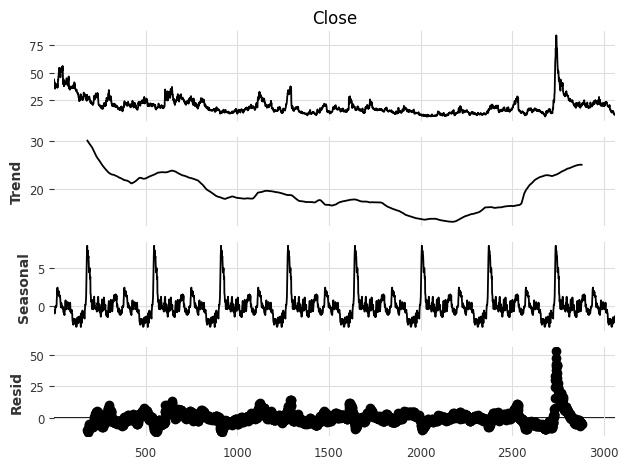

In [105]:
# Seasonal decomposition
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
decomposition.plot()
plt.show()

<Figure size 1200x600 with 0 Axes>

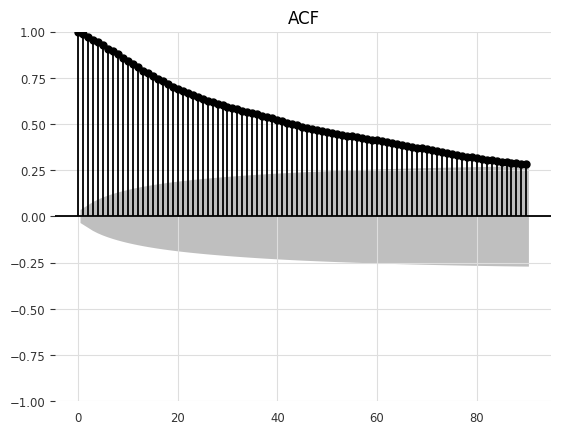

<Figure size 1200x600 with 0 Axes>

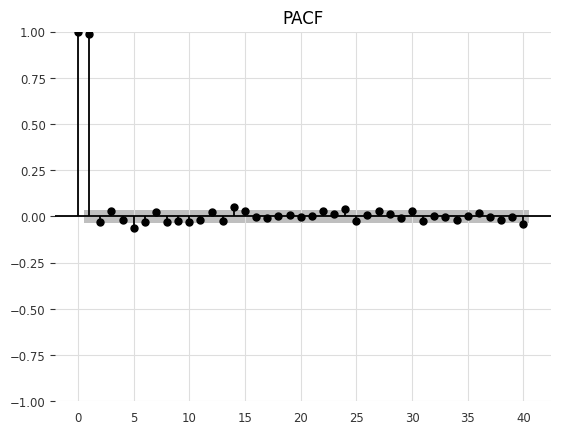

In [106]:
# ACF and PACF plots
plt.figure(figsize=(12, 6))
plot_acf(df['Close'], lags=90, title='ACF')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Close'], lags=40, title='PACF')
plt.show()

In [107]:
df.set_index('Date', inplace=True)

In [108]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use auto_arima to automatically select the best ARIMA model
model = auto_arima(df['Close'], seasonal=True, m=30)  # Assuming a seasonality of 5 in this example

# Fit the SARIMA model using the selected orders
results = SARIMAX(df['Close'], order=model.order, seasonal_order=model.seasonal_order).fit()

# Print model summary
print(results.summary())

C:\Users\Manish Seal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manish Seal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3060
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -5024.701
Date:                Wed, 22 Nov 2023   AIC                          10063.402
Time:                        15:32:26   BIC                          10105.583
Sample:                             0   HQIC                         10078.559
                               - 3060                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9114      0.090     10.131      0.000       0.735       1.088
ar.L2         -0.6996      0.107     -6.524      0.000      -0.910      -0.489
ar.L3          0.4094      0.094      4.334      0.0

Manual arima here

In [109]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # applying SARIMAX here
# p, d, q = 1, 1, 1
# P, D, Q, s = 1, 1 ,1, 5

# # Fit the SARIMA model
# model = SARIMAX(df['Close'], order=(p, d, q), seasonal_order=(P, D, Q, s))
# results = model.fit()

# # Print model summary
# print(results.summary())

Overall, the residuals of this distribtuion is non-normal (as shown in the Jarque-Bera (JB) test). This implies heteroskasdicity

C:\Users\Manish Seal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Manish Seal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


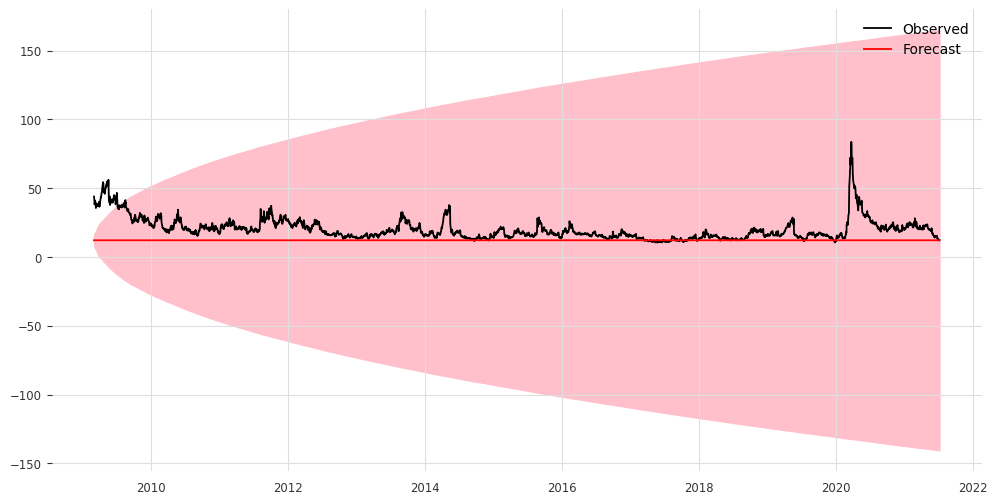

In [110]:
# Forecast future values for the full duration of the time series
forecast_steps = len(df)  # Set the number of forecast steps to the length of your data
forecast = results.get_forecast(steps=forecast_steps)

# Get the predicted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Set the index of forecast_values and confidence_intervals to match the index of your original data
forecast_values.index = df.index
confidence_intervals.index = df.index

# Plot the original data and the forecast for the full duration
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Observed')
plt.plot(forecast_values.index, forecast_values, color='r', label='Forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink')
plt.legend()
plt.show()

seems like a downward trajectory

In [111]:
# list of forecast values
forecast_values

Date
2009-03-03    12.142321
2009-03-04    12.129493
2009-03-05    12.149350
2009-03-06    12.147689
2009-03-09    12.127032
                ...    
2021-07-01    12.115883
2021-07-02    12.115883
2021-07-05    12.115883
2021-07-06    12.115883
2021-07-07    12.115883
Name: predicted_mean, Length: 3060, dtype: float64

## <a id='toc1_2_'></a>[Using LGBM and XGBOOST](#toc0_)

In [112]:
df.columns.values
df_copy = df.reset_index(level=0)
df_copy.columns.values

array(['Date', 'Open', 'High', 'Low', 'Close', 'Previous', 'Change',
       '%Change'], dtype=object)

In [113]:
import pandas as pd
from darts import TimeSeries
from darts.models.forecasting.xgboost import XGBModel
from darts.models.forecasting.lgbm import LightGBMModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality
from darts.utils.missing_values import fill_missing_values


series = TimeSeries.from_dataframe(df_copy, time_col='Date', value_cols='Close',freq='D')
series = fill_missing_values(series)

# Split the series into training and validation sets
train, val = series.split_before(pd.Timestamp('2021-01-01'))

Note: MAPE means mean absolute percentage error here

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93075
[LightGBM] [Info] Number of data points in the train set: 3957, number of used features: 365
[LightGBM] [Info] Start training from score 18.711515
LightGBM MAPE: 18.70%
XGBoost MAPE: 17.29%


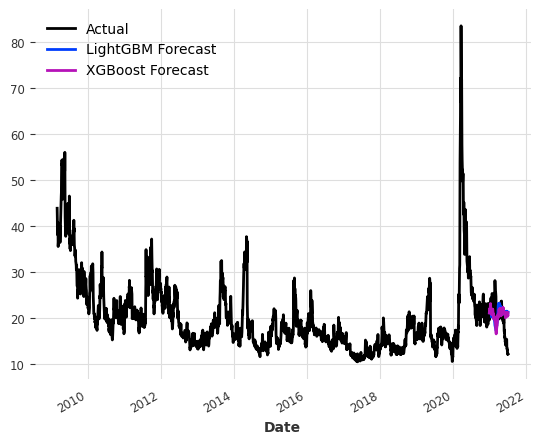

In [114]:
# LightGBM model
lgb_model = LightGBMModel(
    lags=365
)
lgb_model.fit(train)
lgb_forecast = lgb_model.predict(len(val))

# XGBoost model
xgb_model = XGBModel(
    lags=365
)
xgb_model.fit(train)
xgb_forecast = xgb_model.predict(len(val))

# Evaluate the forecasts
lgb_mape = mape(val, lgb_forecast)
xgb_mape = mape(val, xgb_forecast)

# Print MAPE
print(f'LightGBM MAPE: {lgb_mape:.2f}%')
print(f'XGBoost MAPE: {xgb_mape:.2f}%')

# Plot the results
series.plot(label='Actual')
lgb_forecast.plot(label='LightGBM Forecast')
xgb_forecast.plot(label='XGBoost Forecast')
plt.legend()
plt.show()

## <a id='toc1_3_'></a>[With backtesting](#toc0_)

In [115]:
from darts.models.forecasting.lgbm import LightGBMModel
lgb_model = LightGBMModel(lags=30)
lgb_model.fit(val)

# Backtest the model
backtest_results = lgb_model.backtest(series=val)

# Print the backtest results
print(backtest_results)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 158, number of used features: 30
[LightGBM] [Info] Start training from score 20.049293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

With backtesting on lgbm, we can see that the MAPE is 5.7%

In [116]:
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(lags=30)
xgb_model.fit(val)
backtest_result=xgb_model.backtest(series=val)
print(backtest_result)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


3.808803664613802


With XGBOOST, we get a better MAPE of 3.8%